In [11]:
import sys
sys.path.append('/home/v-runmao/projects/DomShift-ATMF')

from importlib import reload
import helper
reload(helper)

from helper import get_model_from_root
from data import ATMFDataset, DomainSampler

from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
import numpy as np
import transformers
import os

sns.set()  # set style
transformers.logging.set_verbosity_error()  # only report error

In [9]:
def create_data_loader(target, n_samples_per_domain):
    """Create a data loader that retrieves uniformly from each domain in a batch.
    """
    full = ATMFDataset('/home/v-runmao/projects/DomShift-ATMF/data/data_root/preprocessed.csv', target)
    bs = DomainSampler(full.domain_ids, n_samples_per_domain, align='truncation')
    loader = DataLoader(full, batch_sampler=bs, num_workers=4, pin_memory=True)
    return loader

In [12]:
def get_embeddings(root, prefix, target, n_total=1024, n_samples_per_domain=8):
    loader = create_data_loader(target, n_samples_per_domain)
    n_domains = len(loader.dataset.domain2id)
    n_steps = n_total // (n_samples_per_domain * n_domains)
    
    bert = get_model_from_root(root, prefix).to('cuda:0')
    bert.eval()
    
    sent_embs = []
    ys = []
    ids = []
    
    # use the same sentences
    np.random.seed(0)
    torch.manual_seed(0)
    
    for i, (x, y, domain_ids) in enumerate(tqdm(loader, total=n_steps)):
        if i >= n_steps:
            break
        
        # forward and get the sentence embeddings
        with torch.no_grad():
            _ = bert(x)
            assert bert.emb is not None
            emb = bert.emb.detach().clone().cpu().numpy()
        
        # accumulate embeddings, labels and domain IDs
        sent_embs.append(emb)
        ys.append(y.numpy())
        ids.append(domain_ids.numpy())
    
    sent_embs = np.concatenate(sent_embs, axis=0)
    ys = np.concatenate(ys, axis=0)
    ids = np.concatenate(ids, axis=0)
        
    return sent_embs, ys, ids

In [15]:
def visualize(exp_name, target):
    n_total = 2048
    n_samples_per_domain = 16
    
    root = os.path.join('/home/v-runmao/projects/DomShift-ATMF/pt', exp_name)
    prefix = f'search_{exp_name}_tgt_{target}'
    sent_embs, ys, ids = get_embeddings(root,
                                        prefix,
                                        target,
                                        n_total,
                                        n_samples_per_domain)
    
    # dimension reduction
    reducer = TSNE()
    reduced = reducer.fit_transform(sent_embs).T  # (2, N)
    
    # plot
    fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    sns.scatterplot(x=reduced[0], y=reduced[1], hue=ids, palette='tab10', ax=axes[0])
    sns.scatterplot(x=reduced[0], y=reduced[1], hue=ys, palette='tab10', ax=axes[1])
    
    fig.show()
    return fig

# Target: MSN

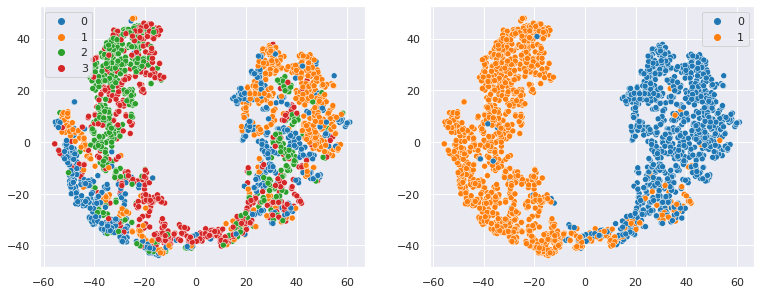

In [5]:
erm_fig = visualize('ERM', 'M')

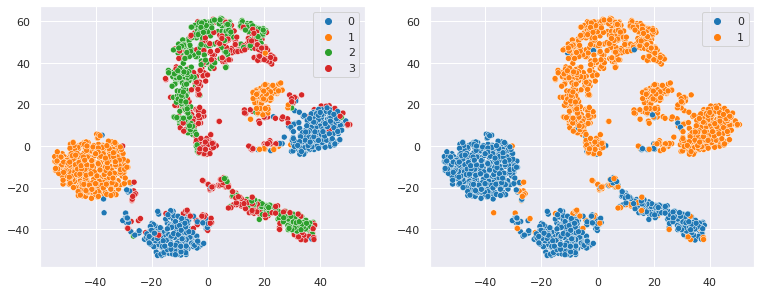

In [6]:
dann_fig = visualize('DANN', 'M')

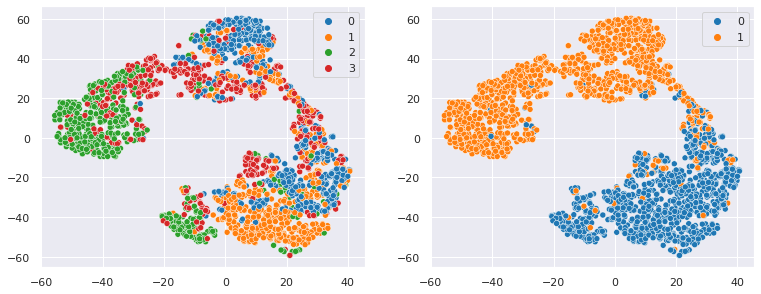

In [7]:
mldg_fig = visualize('MLDG', 'M')

  0%|          | 0/32 [00:00<?, ?it/s]

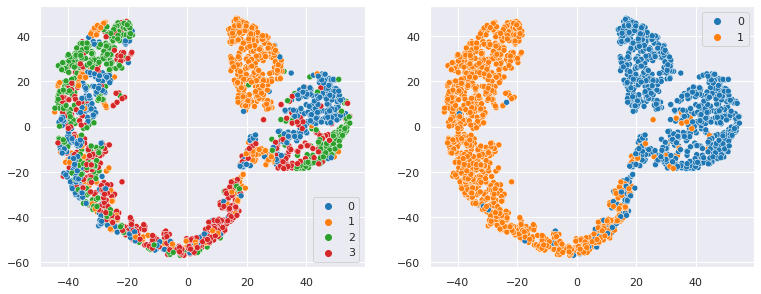

In [16]:
blc_dann_fig = visualize('BlcDANN_default', 'M')

# Target: Twitter

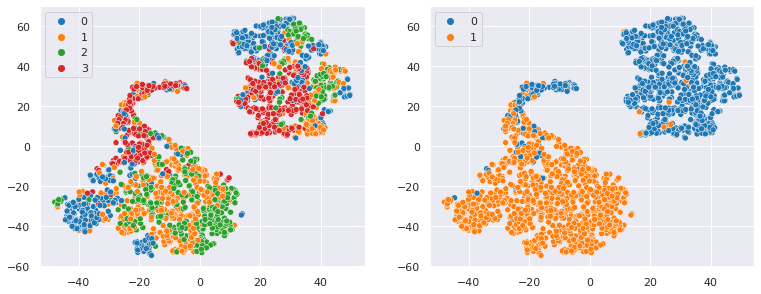

In [8]:
erm_fig_T = visualize('ERM', 'T')

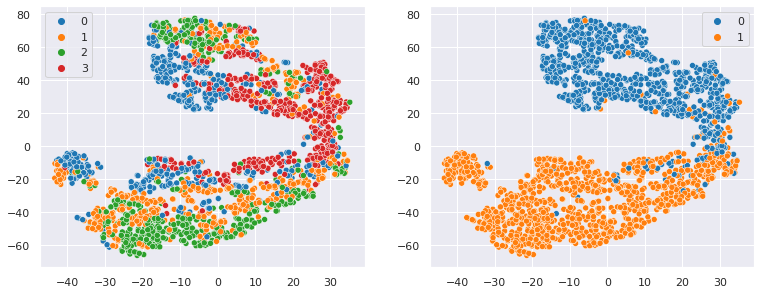

In [9]:
dann_fig_T = visualize('DANN', 'T')

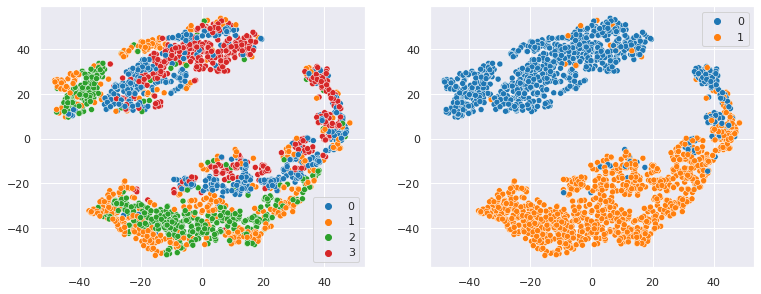

In [10]:
mldg_fig_T = visualize('MLDG', 'T')

  0%|          | 0/32 [00:00<?, ?it/s]

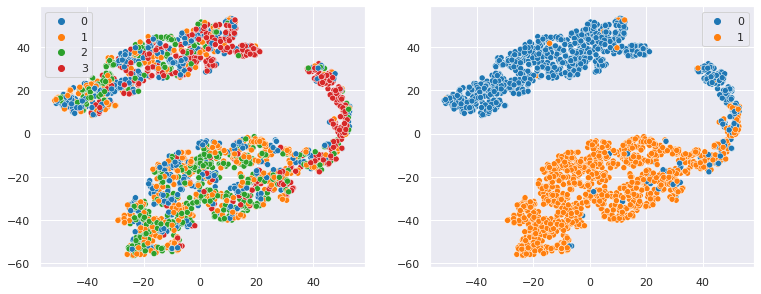

In [17]:
blc_dann_fig = visualize('BlcDANN_default', 'T')

# Target: Amazon

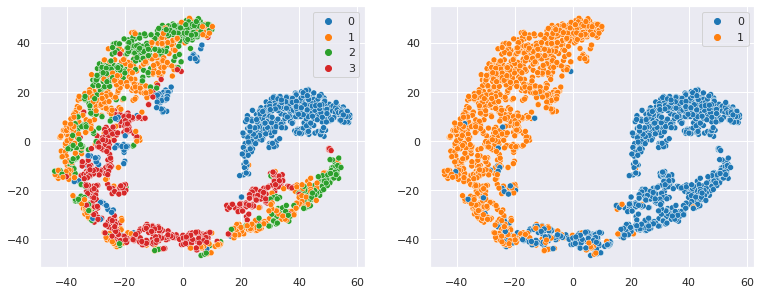

In [11]:
erm_fig_A = visualize('ERM', 'A')

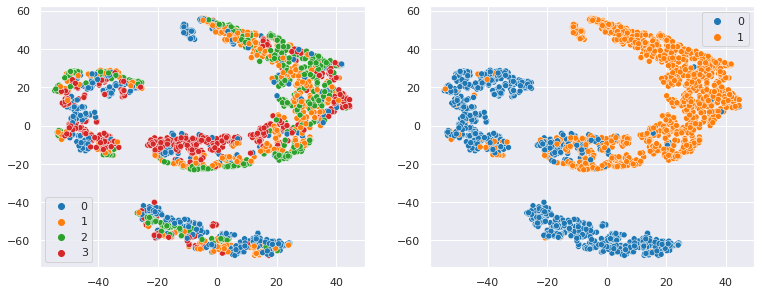

In [12]:
dann_fig_A = visualize('DANN', 'A')

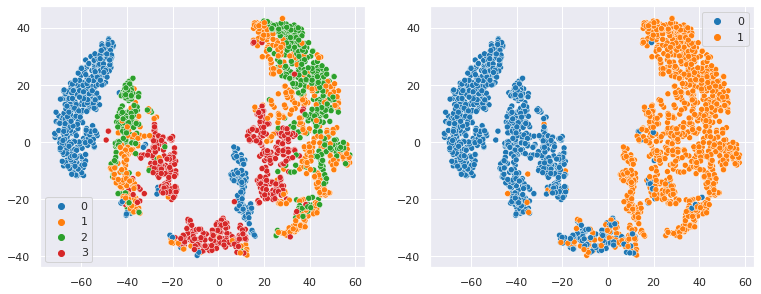

In [13]:
mldg_fig_A = visualize('MLDG', 'A')

  0%|          | 0/32 [00:00<?, ?it/s]

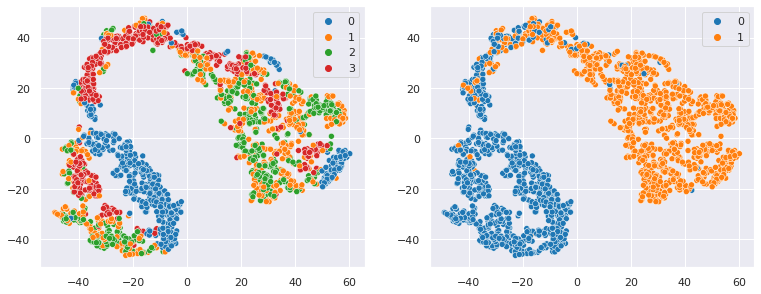

In [18]:
blc_dann_fig_A = visualize('BlcDANN_default', 'A')